In [1]:
import numpy as np, pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

import os, time
import urllib.request 

from biopandas.pdb import PandasPdb
import blosum as bl

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import Levenshtein
from Levenshtein import distance as levenshtein_distance

In [2]:
train_df_group = pd.read_csv('train_with_groups.csv')

# remove group -1:
train_df = train_df_group[train_df_group.group!=-1]
count_by_group = train_df.groupby('group').seq_id.count()

In [3]:
def build_change_list(group_df):
    
    list_output = []
    group_size = len(group_df)
    group_values = group_df.values
    
    col = ['pH','data_source','tm','group']

    for i in range(group_size):
        data1 = group_values[i]
        line1 = data1[1]
        values1  = data1[2:]
        for j in range(group_size):
            data2 = group_values[j]
            line2 = data2[1]
            values2  = data2[2:]
            if i!=j:
                edits = Levenshtein.editops(line1, line2)
                if len(edits)==1:
                    list_output.append(tuple([line1,line2])+edits[0]+tuple(line1[edits[0][1]])+tuple(line2[edits[0][1]])+ tuple(values1) + tuple(values2))
                else:
                    list_output.append(tuple([line1,line2])+('replace', 0, 0, 'A', 'A') + tuple(values1) + tuple(values2))

    changes = pd.DataFrame(list_output,columns=['seq1','seq2','operation','position1','position2','change1','change2']+[c+'1' for c in col] + [c+'2' for c in col])
    changes.change2 = np.where(changes.operation=='delete','',changes.change2)
    
    return changes

In [4]:
%%time

top_n = 10 #408
main_groups = count_by_group.sort_values(ascending=False).index[:top_n]

df_list = []

for i in main_groups:
    print(f'group {i}')
    group_df = train_df[train_df.group==i]
    df = build_change_list(group_df)
    df_list.append(df)

df_sm = pd.concat(df_list)

group 5
group 9
group 15
group 34
group 27
group 28
group 45
group 51
group 50
group 57
CPU times: total: 11.3 s
Wall time: 11.6 s


In [5]:
# clean data a bit - same sources, change in protein, same pH and pH not too far of 7

df_clean = df_sm[(df_sm.data_source1 == df_sm.data_source2)&(df_sm.pH1 == df_sm.pH2)]
df_clean = df_clean[(df_clean.pH1>=6) & (df_clean.pH1<=8)]
df_clean = df_clean[df_clean.position1 != 0]

df_clean['target'] = df_clean['tm2'] - df_clean['tm1'] 

print(len(df_clean))
display(pd.crosstab(df_clean.change1,df_clean.change2).style.background_gradient(axis=None, cmap="YlGnBu"))

2296


change2,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
change1,,,,,,,,,,,,,,,,,,,,
A,0,4,5,3,19,11,9,10,17,18,8,12,5,10,6,16,3,21,5,8
C,4,0,0,0,11,4,4,26,4,4,4,4,0,4,0,30,0,32,0,0
D,5,0,0,2,3,3,4,2,2,3,1,5,1,2,3,4,4,5,1,3
E,3,0,2,0,2,2,1,1,2,3,2,1,1,0,1,2,1,1,2,3
F,19,11,3,2,0,8,9,12,9,38,9,7,1,7,3,12,3,16,6,12
G,11,4,3,2,8,0,5,5,6,8,5,6,0,4,2,9,3,11,1,2
H,9,4,4,1,9,5,0,7,9,8,4,10,1,10,5,7,2,8,2,4
I,10,26,2,1,12,5,7,0,8,17,4,7,1,5,3,31,2,35,2,5
K,17,4,2,2,9,6,9,8,0,7,5,13,3,10,6,8,2,9,4,5


In [6]:
# avg target by protein changes, independtly of emplacement

avg_target = df_clean.groupby(['change1','change2']).target.mean()
display(avg_target.unstack().fillna(0).style.background_gradient(axis=None, cmap="RdYlBu").format('{:.2f}'))

change2,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
change1,,,,,,,,,,,,,,,,,,,,
A,0.00,3.50,-1.64,-4.30,2.98,-5.49,-0.53,6.13,-1.79,6.16,3.06,-3.05,-1.36,-2.00,-3.32,-2.35,-3.53,8.17,-0.64,-3.50
C,-3.50,0.00,0.00,0.00,0.75,-11.80,-4.05,1.07,-13.80,-0.80,2.25,-12.25,0.00,-8.90,0.00,-1.06,0.00,2.52,0.00,0.00
D,1.64,0.00,0.00,1.15,-2.70,0.30,-0.55,-6.55,8.70,-1.20,6.20,2.24,-18.00,-7.05,-5.13,-2.65,0.22,1.18,0.50,-5.47
E,4.30,0.00,-1.15,0.00,6.75,-0.05,6.40,10.40,4.20,5.40,1.20,6.40,-1.00,0.00,9.80,0.55,-0.30,4.50,3.05,2.07
F,-2.98,-0.75,2.70,-6.75,0.00,-4.65,-1.49,0.18,-4.78,-1.17,-0.99,-7.71,-2.40,-7.07,-0.27,-6.09,3.00,5.34,-2.15,-1.77
G,5.49,11.80,-0.30,0.05,4.65,0.00,9.44,13.46,3.15,4.66,11.94,3.07,0.00,2.90,11.00,2.76,0.80,10.05,-2.20,1.35
H,0.53,4.05,0.55,-6.40,1.49,-9.44,0.00,0.81,-2.71,-0.51,6.30,-2.96,-9.40,-1.64,-2.96,-1.14,-4.20,5.85,0.75,-6.25
I,-6.13,-1.07,6.55,-10.40,-0.18,-13.46,-0.81,0.00,-4.26,-0.10,0.90,-7.79,9.00,-4.42,-0.30,-2.92,5.75,0.95,-1.50,-1.58
K,1.79,13.80,-8.70,-4.20,4.78,-3.15,2.71,4.26,0.00,3.26,13.04,-0.33,-3.00,2.02,-5.07,3.64,-9.50,10.69,0.00,-6.78


In [7]:
add_data = pd.read_csv('tm.csv')
add_data.head()

,Unnamed: 0,PDB,WT,position,MUT,dTm,sequence,mutant_seq
0,0,1CQW,V,245,L,2.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
1,1,1CQW,L,95,V,-0.4,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
2,2,1CQW,C,176,F,5.2,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
3,3,1CQW,G,171,Q,3.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
4,4,1CQW,T,148,L,1.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...


In [8]:
pd.crosstab(add_data.WT,add_data.MUT).style.background_gradient(axis=None, cmap="YlGnBu")


MUT,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
WT,,,,,,,,,,,,,,,,,,,,
A,0,1,2,2,2,1,3,0,10,9,9,3,13,4,6,5,3,9,1,5
C,2,0,0,0,2,1,1,2,0,3,2,2,2,1,0,0,2,2,0,1
D,7,0,0,7,4,0,3,1,7,4,0,14,4,2,3,3,3,2,3,2
E,13,1,2,0,1,0,3,3,17,7,5,4,7,14,6,3,2,2,1,7
F,2,0,1,0,0,0,0,1,0,1,2,0,0,0,1,1,1,1,5,3
G,20,0,6,2,2,0,3,3,3,6,2,4,4,5,3,6,2,2,2,7
H,5,0,0,0,3,1,0,1,1,2,4,2,1,2,4,1,0,2,1,7
I,3,1,3,3,2,0,3,0,1,6,2,4,2,0,0,1,2,6,0,0
K,7,0,0,2,2,1,3,1,0,4,1,0,1,2,4,1,0,0,1,2


In [9]:
avg_target2 = add_data.groupby(['WT','MUT']).mean().dTm
display(avg_target2.unstack().fillna(0).style.background_gradient(axis=None, cmap="RdYlBu").format('{:.2f}'))

C:\Users\Emilie\AppData\Local\Temp\ipykernel_30180\4167827643.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_target2 = add_data.groupby(['WT','MUT']).mean().dTm


MUT,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
WT,,,,,,,,,,,,,,,,,,,,
A,0.00,0.50,0.60,-0.13,3.00,2.60,0.50,0.00,-0.61,0.59,0.54,1.27,-0.01,-1.17,0.14,-0.34,1.03,0.17,4.80,-0.90
C,-2.29,0.00,0.00,0.00,2.65,-11.40,-11.50,-3.62,0.00,-0.75,0.25,11.15,-3.75,-1.07,0.00,0.00,0.00,-7.75,0.00,0.50
D,-1.99,0.00,0.00,-1.45,-2.00,0.00,-4.50,0.50,-0.05,-3.23,0.00,-0.84,-1.45,2.12,-0.73,0.08,-4.43,-0.50,-0.83,-0.75
E,-0.04,3.30,-0.18,0.00,1.60,0.00,-1.67,3.73,0.36,1.14,-0.92,-1.25,-0.71,0.60,1.46,1.56,2.65,2.75,2.70,-0.10
F,-0.36,0.00,-7.80,0.00,0.00,0.00,0.00,0.00,0.00,-9.20,0.20,0.00,0.00,0.00,0.40,-2.60,2.70,-2.50,-0.30,-0.07
G,0.94,0.00,-0.11,1.00,-2.25,0.00,-1.67,-1.00,-0.67,1.57,1.75,0.30,-0.50,-3.86,-5.93,0.92,-6.50,-2.75,-7.85,0.57
H,-0.40,0.00,0.00,0.00,-0.67,4.90,0.00,-6.30,-0.50,0.50,-4.83,0.39,0.80,1.50,-0.50,-3.90,0.00,-1.45,0.50,-0.79
I,-5.90,-2.00,0.90,-5.22,1.45,0.00,2.93,0.00,0.00,-1.33,2.15,0.29,0.50,0.00,0.00,-14.90,-2.30,1.27,0.00,0.00
K,-1.02,0.00,0.00,-6.25,2.50,0.00,-0.75,2.50,0.00,0.79,3.50,0.00,-10.50,-1.75,-0.81,-2.50,0.00,0.00,3.50,1.75


In [10]:
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'

test_df = pd.read_csv("test.csv")

In [11]:
def change_list(wild, mutation_list):

    list_output = []

    for mutation in mutation_list:
        edits = Levenshtein.editops(wild, mutation)
        if len(edits):
            list_output.append(edits[0]+tuple(mutation[edits[0][1]])+tuple(base[edits[0][1]]))
        else:
            list_output.append(('replace', 0, 0, 'A', 'A'))

    changes = pd.DataFrame(list_output,columns=['operation','position1','position2','change1','change2'])
    changes.change2 = np.where(changes.operation=='delete','',changes.change2)
    
    return changes

In [12]:
changes = change_list(base, test_df.protein_sequence.to_list())
changes.operation.value_counts()

replace    2336
delete       77
Name: operation, dtype: int64

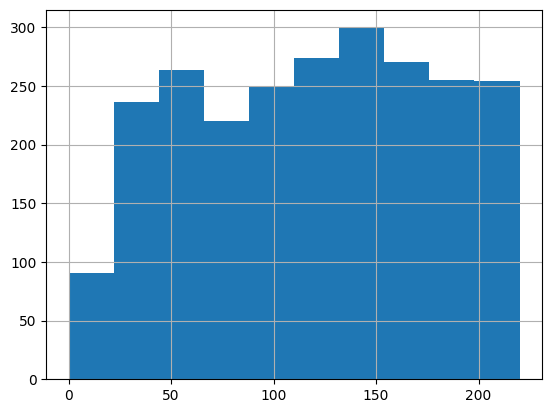

In [13]:
changes.position1.hist();


In [14]:
pd.crosstab(changes.change1,changes.change2).style.background_gradient(axis=None, cmap="YlGnBu")

change2,,A,D,E,F,G,I,K,L,N,P,Q,R,S,T,V,W,Y
change1,,,,,,,,,,,,,,,,,,
A,6,1,9,4,4,15,4,13,8,10,10,7,1,12,4,7,2,4
C,1,13,8,3,5,10,4,19,7,12,10,8,2,12,4,5,3,5
D,3,11,0,4,4,13,2,16,6,10,6,10,3,10,4,5,3,2
E,1,14,7,0,4,13,3,13,7,12,9,10,3,13,7,5,4,4
F,7,17,8,4,0,13,4,16,7,10,6,10,2,16,4,5,4,5
G,8,16,7,3,3,0,3,16,5,10,7,11,2,12,3,7,2,3
H,0,10,8,5,3,12,2,16,3,13,10,8,2,12,3,5,2,4
I,4,12,5,3,6,13,0,18,5,11,10,6,1,12,4,7,4,3
K,10,12,7,2,1,10,4,0,6,12,5,10,2,10,5,4,3,1


In [15]:
test_df['past_tm'] = changes.merge(avg_target,left_on=['change1','change2'],right_index=True,how='left').target.fillna(0)
test_df['past_tm2'] = changes.merge(avg_target2,left_on=['change1','change2'],right_index=True,how='left').dTm.fillna(0)

In [16]:
PDB_FILE = "wildtype_structure_prediction_af2.pdb"
pdb_df =  PandasPdb().read_pdb(PDB_FILE)
pdb_df.df.keys()

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

In [17]:
dict_enzyme = {
    'ALA':'A',
    'ARG':'R',
    'ASN':'N',
    'ASP':'D',
    'CYS':'C',
    'GLU':'E',
    'GLN':'Q',
    'GLY':'G',
    'HIS':'H',
    'ILE':'I',
    'LEU':'L',
    'LYS':'K',
    'MET':'M',
    'PHE':'F',
    'PRO':'P',
    'SER':'S',
    'THR':'T',
    'TRP':'W',
    'TYR':'Y',
    'VAL':'V'
}

atom_df = pdb_df.df['ATOM']
atom_df['residue_letter'] = atom_df.residue_name.map(dict_enzyme)

In [18]:
fig = px.scatter_3d(atom_df, x = "x_coord",
                    y = "y_coord",
                    z = "z_coord",
                    color = "residue_letter")
fig.update_traces(marker = dict(size = 3))
fig.update_coloraxes(showscale = False)
fig.update_layout(template = "plotly_dark")
fig.show()

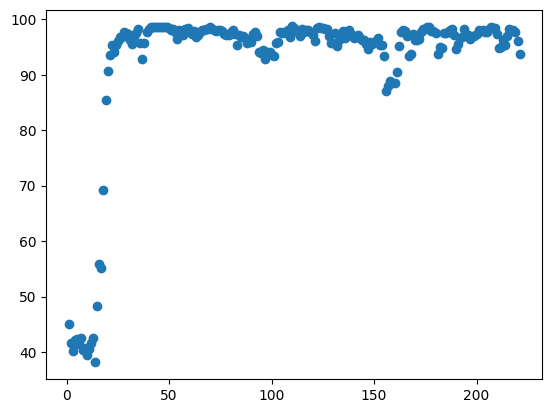

In [19]:
test_df['modif'] = changes.position1

map_number_to_b = atom_df.groupby('residue_number').b_factor.mean()
test_df['b_factor'] = (test_df.modif+1).map(map_number_to_b).fillna(0)

atom_df['distance'] = np.sqrt(np.square(atom_df.x_coord) + np.square(atom_df.y_coord) + np.square(atom_df.z_coord))
map_number_to_distance = atom_df.groupby('residue_number').distance.mean()
test_df['distance'] = (test_df.modif+1).map(map_number_to_distance).fillna(0)

plt.scatter(map_number_to_b.index, map_number_to_b.values);

In [20]:
fig = px.scatter_3d(atom_df, x = "x_coord",
                    y = "y_coord",
                    z = "z_coord",
                    color = "b_factor")
fig.update_traces(marker = dict(size = 3))
fig.update_coloraxes(showscale = False)
fig.update_layout(template = "plotly_dark")
fig.show()

In [21]:
# try to improve b-factor prediction by composition of amino acid - not really working
#remove outliers ?

atom_remove_low = atom_df[atom_df.b_factor>80].copy()

X = atom_remove_low.groupby(['residue_number','element_symbol']).size().unstack(fill_value=0)
y = atom_remove_low.groupby(['residue_number']).b_factor.mean()

reg = LinearRegression().fit(X, y)

X.index = atom_remove_low.groupby('residue_number').residue_letter.first()

value_by_letter = pd.DataFrame({'letter':X.index, 'pred':reg.predict(X)})
map_b_by_letter = value_by_letter.groupby('letter').mean()

changes['Delta1'] = changes.change1.map(map_b_by_letter['pred'])
changes['Delta2'] = changes.change2.map(map_b_by_letter['pred'])
changes['Delta'] = (changes['Delta2'] - changes['Delta1']).fillna(0)

In [22]:
PDB_ex = add_data.PDB.iloc[0]
PDB_ex_df = urllib.request.urlretrieve(f'http://files.rcsb.org/download/{PDB_ex}.pdb', f'{PDB_ex}.pdb')

In [23]:
PDB_FILE = f"./{PDB_ex}.pdb"
pdb_df =  PandasPdb().read_pdb(PDB_FILE)
pdb_df.df.keys()

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

In [24]:
atom_df = pdb_df.df['ATOM']
atom_df['residue_letter'] = atom_df.residue_name.map(dict_enzyme)

In [25]:
fig = px.scatter_3d(atom_df, x = "x_coord",
                    y = "y_coord",
                    z = "z_coord",
                    color = 'residue_letter')
fig.update_traces(marker = dict(size = 3))
fig.update_coloraxes(showscale = False)
fig.update_layout(template = "plotly_dark")
fig.show()

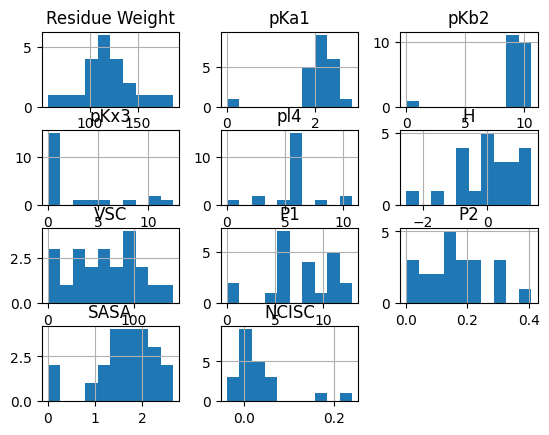

In [27]:
properties = pd.read_csv('aminoacids.csv')
properties = properties[['Letter', 'Residue Weight', 'pKa1', 'pKb2', 'pKx3', 'pl4', 'H', 'VSC', 'P1', 'P2', 'SASA', 'NCISC']]
properties = properties.set_index('Letter').fillna(0)

properties.hist();

In [28]:
changes = changes.merge(properties.add_suffix('1'),left_on='change1',right_index=True,how='left')
changes = changes.merge(properties.add_suffix('2'),left_on='change2',right_index=True,how='left')
changes = changes.fillna(0)

for c in ['Residue Weight', 'pKa1', 'pKb2', 'pKx3', 'pl4', 'H', 'VSC', 'P1', 'P2', 'SASA', 'NCISC']:
    changes['Delta '+c] = changes[c+'1']-changes[c+'2']

In [29]:
matrix = bl.BLOSUM(80) # 45, 50, 62, 80 and 90

changes_str = changes.change1 + changes.change2
test_df['blosum_score'] = changes_str.apply(lambda x: matrix[x])
test_df['blosum_score'] = np.nan_to_num(test_df['blosum_score'],nan=0.0, posinf=10, neginf=-10)

test_df['blosum_score_adj'] = (1 / (1+np.exp(-test_df['blosum_score'])))
test_df['b_factor_adj'] = test_df['b_factor'] * test_df['blosum_score_adj'] 

test_df['rank_blosum'] = (test_df['blosum_score_adj']).transform('rank')
test_df['rank_b_factor'] = (-test_df['b_factor']).transform('rank')

test_df['avg_rank'] = test_df['rank_blosum'] + 1.2*test_df['rank_b_factor']

In [30]:
position_change = changes.position1.value_counts()
old_prot_count = changes.change1.value_counts()
new_prot_count = changes.change2.value_counts()

In [31]:
changes['count_pos'] = changes.position1.map(position_change)
changes['old_prot_count'] = changes.change2.map(old_prot_count)
changes['new_prot_count'] = changes.change2.map(new_prot_count)
changes = changes.fillna(0)

In [32]:
all_feature = pd.concat([test_df[['pH', 'past_tm', 'b_factor', 'distance', 'blosum_score', 'past_tm2']],changes[['position1', 'Delta', 'Delta Residue Weight', 'Delta pKa1', 'Delta pKb2', 'Delta pKx3', 'Delta pl4', 'Delta H', 'Delta VSC', 'Delta P1', 'Delta P2', 'Delta SASA', 'Delta NCISC', 'count_pos', 'old_prot_count','new_prot_count']]],axis=1)
all_feature.corr('spearman').style.background_gradient(axis=None, cmap="YlGnBu").format('{:.2f}')

,pH,past_tm,b_factor,distance,blosum_score,past_tm2,position1,Delta,Delta Residue Weight,Delta pKa1,Delta pKb2,Delta pKx3,Delta pl4,Delta H,Delta VSC,Delta P1,Delta P2,Delta SASA,Delta NCISC,count_pos,old_prot_count,new_prot_count
pH,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
past_tm,nan,1.00,0.09,-0.04,0.14,0.01,-0.02,0.19,0.02,0.06,-0.09,0.13,0.01,-0.30,-0.12,0.34,-0.05,-0.03,0.15,-0.03,0.05,-0.15
b_factor,nan,0.09,1.00,-0.69,-0.01,-0.01,0.01,0.13,-0.05,-0.05,-0.13,0.01,-0.01,-0.16,-0.09,0.16,-0.08,-0.06,-0.06,-0.04,0.16,-0.24
distance,nan,-0.04,-0.69,1.00,0.01,-0.00,-0.00,-0.11,-0.04,0.10,0.19,-0.11,-0.03,0.21,-0.01,-0.16,-0.01,-0.04,0.13,-0.09,-0.20,0.19
blosum_score,nan,0.14,-0.01,0.01,1.00,-0.01,-0.01,0.25,-0.21,-0.14,-0.11,0.01,-0.06,-0.18,-0.24,0.17,-0.21,-0.21,0.02,-0.01,0.09,0.10
past_tm2,nan,0.01,-0.01,-0.00,-0.01,1.00,0.02,0.10,-0.08,0.10,0.03,0.01,-0.02,-0.01,-0.06,0.06,-0.10,-0.06,-0.10,-0.02,0.02,-0.02
position1,nan,-0.02,0.01,-0.00,-0.01,0.02,1.00,0.05,-0.09,-0.01,0.08,-0.04,-0.01,-0.01,-0.09,0.02,-0.09,-0.08,0.00,0.04,0.03,0.01
Delta,nan,0.19,0.13,-0.11,0.25,0.10,0.05,1.00,-0.16,-0.08,-0.38,0.07,0.10,-0.62,-0.28,0.70,-0.31,-0.15,-0.18,-0.09,0.18,-0.20
Delta Residue Weight,nan,0.02,-0.05,-0.04,-0.21,-0.08,-0.09,-0.16,1.00,-0.04,-0.31,0.44,0.14,-0.28,0.89,0.09,0.94,0.96,-0.13,0.00,-0.00,0.25
Delta pKa1,nan,0.06,-0.05,0.10,-0.14,0.10,-0.01,-0.08,-0.04,1.00,0.17,-0.18,0.30,0.34,0.13,-0.25,0.02,0.06,0.24,0.00,-0.00,-0.16


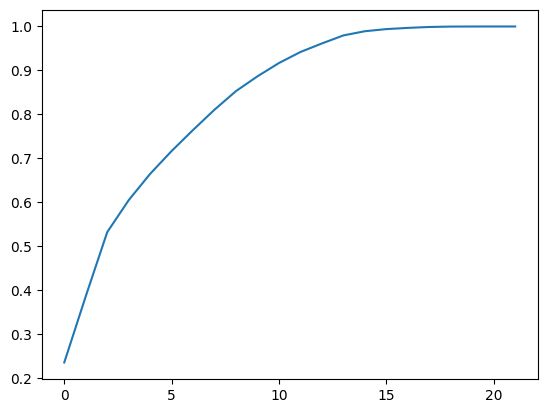

In [33]:
pca = PCA()
scaler = StandardScaler()
all_feature = scaler.fit_transform(all_feature)
all_feature = pca.fit_transform(all_feature)

plt.plot(pca.explained_variance_ratio_.cumsum())

In [34]:
pd.DataFrame(all_feature).corrwith(test_df['b_factor'], method='spearman')


d:\repositories\predictimpactvenv\myenv\lib\site-packages\scipy\stats\_stats_py.py:4881: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



0    -0.067313
1     0.107031
2     0.279806
3    -0.633486
4    -0.002805
5     0.059475
6    -0.269341
7    -0.072461
8    -0.192423
9    -0.029544
10    0.058505
11    0.204650
12    0.052528
13   -0.035417
14   -0.014058
15   -0.016642
16    0.044021
17    0.006165
18    0.024465
19    0.011568
20    0.022180
21         NaN
dtype: float64

In [35]:
alpha = 0
variables = ['Residue Weight', 'pKa1', 'pKb2', 'pKx3', 'pl4', 'H', 'VSC', 'P1', 'P2', 'SASA', 'NCISC']

submission = pd.DataFrame()
submission["tm"] =  test_df['avg_rank']
submission["seq_id"] = test_df["seq_id"]
submission.to_csv("submission.csv", index=False)
